# Training, Evaluating and Comparing Models

In this notebook, different model architectures will be trained on the main data
as well as on the integrated data. All models will be evaluated, and finally
compared to another to select the best performing one.

Here, the train, val and test data is just loaded from files.
The data analysis and preparation was done in the notebook
`01-data_preparation.ipynb`.

## Preparations

In [75]:
# dependencies
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error

# paths
PATH_DATA = Path("../data/processed/main/")
PATH_MODELS = Path("../models/")

In [2]:
# load data

# train data
X_train = pd.read_csv(PATH_DATA / "sleep_data_main_train_features.csv")
y_train = pd.read_csv(PATH_DATA / "sleep_data_main_train_labels.csv")

# test data
X_test = pd.read_csv(PATH_DATA / "sleep_data_main_test_features.csv")
y_test = pd.read_csv(PATH_DATA / "sleep_data_main_test_labels.csv")

# no validation data used, because models are tuned using cross validation

In [3]:
# define function to train model with grid search
def train_model_with_gridsearch(row):
    """
    Train model using GridSearchCV and return best results.
    
    Parameters:
    -----------
    row: pd.Series
        A row from the data frame containing the model and its parameter grid.
    
    Returns:
    --------
    pd.Series
        A series with the best parameters, best RMSE and best model.
    """
    
    # setup grid search
    grid_search = GridSearchCV(
        estimator=row['model'],
        param_grid=row['param_grid'],
        scoring='neg_root_mean_squared_error',  # sklearn uses negative RMSE
        cv=5,                                   # 5-fold cross-validation
        n_jobs=-1,                              # use all cores
        verbose=1
    )
    
    # fit grid search
    grid_search.fit(X_train, y_train.squeeze())
    
    # get best results and convert back to positive RMSE
    best_rmse = -grid_search.best_score_
    # get std of best model
    rmse_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    
    return pd.Series({
        'best_params': grid_search.best_params_,
        'best_rmse': round(best_rmse, 4),
        'rmse_std': round(rmse_std, 4),
        'best_model': grid_search.best_estimator_
    })

In [64]:
# function for comparing model performance
def calculate_differences_rmse(model_1, model_2, rmse_1, rmse_2):
    """
    Calculate the absolute and percentage difference of RMSE between two models.
    
    Parameters:
    -----------
    model_1: str
        Name of the first model.
    model_2: str
        Name of the second model.
    rmse_1: float
        RMSE of the first model.
    rmse_2: float
        RMSE of the second model.
        
    Returns:
    --------
    None, but prints the absolute and percentage difference.
    """
    
    # calculate absolute difference
    absolute_difference = round(abs(rmse_1 - rmse_2), 4)

    # calculate percentage difference
    percentage_difference = round((absolute_difference / rmse_1) * 100, 4)

    print(f"Model 1: {model_1} - Model 2: {model_2}")
    print(f"Absolute difference: {absolute_difference}")
    print(f"Percentage difference: {percentage_difference}%")
    print("\n")

In [4]:
# after selecting final model
def evaluate_final_model(best_model):
    """Only use test set once at the very end."""
    test_pred = best_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    return test_rmse

## Hyperparameter Tuning Using Grid Search

Solve it using Scikit-Learn's built in function for grid search.
Scikit learn has a function for this that should be used.

Use cross-validation for all model selection/comparison.
No validation set is needed here.

The data I use for this project is kind of tiny.
The main version has just 500 rows, and the integrated version has just a few
hundred more.
I can afford to make a huge grid here and try many different algorithms.
If the data was larger, I couldn't afford this, but it isn't.
So, I can just go for it.

### Explanation of Grid

This grid provides a good balance between:

- Simple and complex models
- Overfitting prevention and model flexibility
    - Small dataset size → more focus on preventing overfitting
    - Synthetic data → included both simple and complex models
- Computation time and thoroughness of search
- Different approaches to handling the multi-modal target

1. Linear Regression

- Simplest model, serves as baseline
- Limited parameters but important to test both with/without intercept
- Positive constraint might help if relationships are known to be positive

2. Ridge Regression

- Good for small data sets
- Adds L2 regularization to linear regression
- Wide range of alpha values to find optimal regularization
- Small alpha values allow model to be close to linear regression
- Large alpha values force coefficients toward zero

3. Elastic Net

- Good for small data sets
- Combines L1 and L2 regularization
- l1_ratio=0 is Ridge, l1_ratio=1 is Lasso
- Good for feature selection and handling correlated features

4. Decision Tree

- Single tree model, good for interpretability
- max_depth controls complexity (None means unlimited)
- min_samples parameters prevent overfitting
- max_features options help with feature selection

5. Random Forest

- Ensemble of trees using bagging
- More trees generally better but with diminishing returns
- bootstrap controls whether to use sampling with replacement
- Other parameters similar to single tree but can be less restrictive

6. Extra Trees

- Similar to Random Forest but with random splits
- Generally needs more trees due to increased randomness
- Often better at preventing overfitting
- Parameters similar to Random Forest

7. XGBoost

- learning_rate controls how much each tree contributes
- subsample and colsample help prevent overfitting
- min_child_weight and gamma provide additional regularization
- Generally needs more careful tuning than other models

In [5]:
# create dataframe with models and their parameter grids
# make the grid
models_df = pd.DataFrame([
    {
        'name': 'linear_regression',
        'model': LinearRegression(),
        'param_grid': {
            'fit_intercept': [True, False],
            'positive': [True, False]
        }
    },
    {
        'name': 'ridge',
        'model': Ridge(random_state=1337),
        'param_grid': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            'fit_intercept': [True, False]
        }
    },
    {
        'name': 'elastic_net',
        'model': ElasticNet(random_state=1337),
        'param_grid': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
            'fit_intercept': [True, False]
        }
    },
    {
        'name': 'decision_tree',
        'model': DecisionTreeRegressor(random_state=1337),
        'param_grid': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    {
        'name': 'random_forest',
        'model': RandomForestRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }
    },
    {
        'name': 'extra_trees',
        'model': ExtraTreesRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    {
        'name': 'xgboost',
        'model': xgb.XGBRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 4, 5, 6, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2]
        }
    }
])

# show the grid
models_df

,name,model,param_grid
0,linear_regression,LinearRegression(),"{'fit_intercept': [True, False], 'positive': [..."
1,ridge,Ridge(random_state=1337),"{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0..."
2,elastic_net,ElasticNet(random_state=1337),"{'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio':..."
3,decision_tree,DecisionTreeRegressor(random_state=1337),"{'max_depth': [3, 5, 7, 10, None], 'min_sample..."
4,random_forest,"RandomForestRegressor(n_jobs=-1, random_state=...","{'n_estimators': [50, 100, 200, 300], 'max_dep..."
5,extra_trees,"ExtraTreesRegressor(n_jobs=-1, random_state=1337)","{'n_estimators': [50, 100, 200, 300], 'max_dep..."
6,xgboost,"XGBRegressor(base_score=None, booster=None, ca...","{'n_estimators': [50, 100, 200, 300], 'max_dep..."


In [6]:
# apply grid search to each model
results = models_df.apply(train_model_with_gridsearch, axis=1)

# add results to models_df
models_df = pd.concat([models_df, results], axis=1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


In [7]:
# print results: Model, best parameters and corresponding RMSE
for _, row in models_df.iterrows():
    print(f"\nModel: {row['name']}")
    print(f"Best parameters: {row['best_params']}")
    print(f"Best RMSE: {row['best_rmse']} ± {row['rmse_std']}")


Model: linear_regression
Best parameters: {'fit_intercept': True, 'positive': True}
Best RMSE: 0.3379 ± 0.0144

Model: ridge
Best parameters: {'alpha': 10.0, 'fit_intercept': True}
Best RMSE: 0.3384 ± 0.0162

Model: elastic_net
Best parameters: {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.3}
Best RMSE: 0.3301 ± 0.0133

Model: decision_tree
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Best RMSE: 0.35 ± 0.0158

Model: random_forest
Best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: 0.3353 ± 0.0156

Model: extra_trees
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: 0.3317 ± 0.0148

Model: xgboost
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50

Even with this extensive grid and multiple ten thousands of fits, for this small
data set the computation time was just a few minutes.
As I said, with a larger data set, the grid would have to be significantly
reduced in size. Here, however, it's possible to do this.

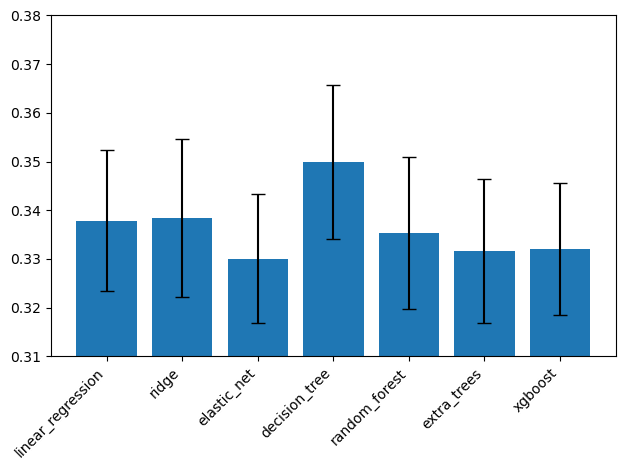

In [9]:
# get data for plotting
results_visualization = models_df[["name", "best_rmse", "rmse_std"]]

# plot results
plt.bar(
    x=range(len(results_visualization)),
    height=results_visualization["best_rmse"],
    yerr=results_visualization["rmse_std"],
    capsize=5,
    tick_label=results_visualization["name"]
)

# set y-axis range
plt.ylim(0.31, 0.38) 

# rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# adjust layout to prevent label cutoff
plt.tight_layout()

### Choose final model based on CV results and practical considerations

All model's performance is similar. 
It's actually really close.
Elastic Nets have a slight edge here.
This may be due to more regularization, which is good for small data sets.

The three best performing models are in this order:
Elastic Net, Extra Trees and XGBoost.

A general rule of thumb is that you can justify using a worse performing model
if the difference is less than 5%, and the worse performing model yields other
benefits.

Below, I calculate the absolute and relative differences between the RMSEs
between the three best models briefly.

In [63]:
# compare the difference in performance between the best performing models
# Extra Trees, XGBoost and Elastic Nets

# get performance as objects
rmse_extra_trees = float(best_models_rmse["best_rmse"][best_models_rmse["name"] == "extra_trees"].iloc[0])
rmse_xgboost = float(best_models_rmse["best_rmse"][best_models_rmse["name"] == "xgboost"].iloc[0])
rmse_elastic_net = float(best_models_rmse["best_rmse"][best_models_rmse["name"] == "elastic_net"].iloc[0])


# compare Extra Trees and XGBoost
calculate_differences_rmse(
    "Extra Trees",
    "XGBoost",
    rmse_extra_trees,
    rmse_xgboost
)

# compare Extra Trees and Elastic Net
calculate_difference(
    "Extra Trees",
    "Elastic Net",
    rmse_extra_trees,
    rmse_elastic_net
)

# compare XGBoost and Elastic Net
calculate_difference(
    "XGBoost",
    "Elastic Net",
    rmse_xgboost,
    rmse_elastic_net
)

Model 1: Extra Trees - Model 2: XGBoost
Absolute difference: 0.0003
Percentage difference: 0.0904%


Model 1: Extra Trees - Model 2: Elastic Net
Absolute difference: 0.0016
Percentage difference: 0.4824%


Model 1: XGBoost - Model 2: Elastic Net
Absolute difference: 0.0019
Percentage difference: 0.5723%




In all cases, the difference in RMSE, which is our measure of performance, is
less than 5%.
To be more precise, in all cases, the difference is even less than 1%.

This means that choosing any of the three models Elastic Net, Extra Trees and
XGBoost is justified, because their performance is close to equal.

### Things to consider for selecting a model

After pre-selecting based on performance metrics (such as RMSE in this case),
these are some of the things to consider:

- If difference in RMSE is small, prefer simpler models
- Elastic net is best regarding here RMSE, but I want feature importance to find
out which features have greatest influence on sleep quality. 
Trees are better for this.
Using the feature importance to gain insight in this is a large part of what
motivated me to choose this as my project in the first place.
- If the models were larger, their prediction / inference speed would become a
factor to consider, but all these are pretty tiny, so I can ignore it.
- It's also possible to stack models as ensemble using StackingRegressor. That
way it would be possible to use Extra Trees for feature importance and use a
stacked model ensemble of Extra Trees and Elastic Nets for prediction.

### Applying this to my case

- Extra Trees and XGBoost perform almost equally.
On average, Extra Trees has a slightly lower RMSE,
but a larger standard deviation.
The difference in RMSE is less than 5%.
- Extra Trees is generally less complex than XGBoost
- Extra Trees is less prone to overfitting
- Extra Trees tends to be more reliable and stable regarding feature importance
    - Averages across many independent trees
    - Less prone to bias compared to boosting methods
    - More consistent across different runs due to randomized nature
- XGBoost's feature importance may be somewhat less reliable under certain
circumstances
    - More sensitive to parameter tuning
    - Sometimes biased towards continuous features or high cardinality
    categorical features
    - Less stable across different runs due to the sequential nature of boosting
- I want to select the simplest solution, at equal performance.
Building a stacked ensemble would make things unnecessarily complicated, so I
will not do that.

### Conclusion

**I choose `Extra Trees`** to be my final model.
It is most likely the best option for my specific use case.
Even though, the other two options would likely also have been viable 
approaches.

The following parameters were identified as the best performing ones:
```
    {'max_depth': 3,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 100}
```

- While its RMSE is slightly larger than that of Elastic Nets, the difference
is just 0.4824%, so that's totally reasonable.
- It allows for easily accessing feature importance. While Elastic Nets also
allow for interpretations, determining the feature importance is just superior
in tree based models. In Extra Trees, the feature importance is more reliable
than in XGBoost.
- Extra Trees is a simpler algorithm than XGBoost, so it's preferrable if
performance is equal. It is also simpler than a stacked ensemble.

## Train Final Model and Evaluate it on the Test Set

Now that an algorithm and hyperparameters were selected using cross-validation,
a final model needs to be trained according to this using the entire
train data set.

Subsequently, its final performance needs to be evaluated using the held-out
test set. This must only happen once at the very end after hyperparameter
tuning and model selection to:

- Prevent test set leakage
- Avoid unconscious bias in model selection
- More honest evaluation of final model
- Protection against overfitting to test set

### Train Final Model


In [68]:
# initialize final model
final_model = ExtraTreesRegressor(
    max_depth=3,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=100,
    random_state=1337,
    n_jobs=-1
)

# have a look at it to double check
final_model

ExtraTreesRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=4,
                    min_samples_split=10, n_jobs=-1, random_state=1337)

In [69]:
# fit the model on all training data
final_model.fit(X_train, y_train.squeeze())

ExtraTreesRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=4,
                    min_samples_split=10, n_jobs=-1, random_state=1337)

### Evaluate Final Model on Test Set

In [82]:
# get predictions of the model on the test set
y_pred = final_model.predict(X_test)

# calculate RMSE of final model using test set and predictions
test_rmse = root_mean_squared_error(y_test, y_pred)

# print results
print(f"RMSE on test set: {test_rmse:.4f}")
print(f"RMSE during cross validation: {rmse_extra_trees:.4f}")

RMSE on test set: 0.3294
RMSE during cross validation: 0.3317


#### Interpretation of Test Set Evaluation
An RMSE of 0.3294 means that, on average, the predictions deviate by 0.3294
units from the true values.
Here, I scaled all the labels to an interval between 0 and 1.
This allows for some interpretation.
The error is quite substantial, and the model is not very accurate.
On average, it is about 32.94% off.
For convenience, I will round that to 33%, which is about a third.
One third of the full range is quite bad.

However, as seen during hyperparameter tuning, all the other models also have a
comparative performance, and no set of hyperparameters was able to improve that.

Now, why may that be the case?
I think it is most likely a combination of three factors.
The first one is the size of the data set. It has no more than 500 examples.
The second one is that I removed multiple features, which may would
have been helpful under regular circumstances, to facilitate meaningful
deployment as a service.
Finally, it is a synthetic data set, and the distributions didn't look too
convincing.

So, all in all, the model is not overwhelming, but it is important to consider
that it was trained on tiny data.
I really fell in love with the idea of building a tool for sleep quality
prediction and investigating the influence of certain variables.
I still think the idea is cool!
However, the data was quite questionable from the beginning, and for the next
project, I will have to find a larger data set
Also I am still a learner, and I need to improve much, much more to make the
best out even data like this.

### Feature Importance

Todo: Take a look at feature importance here.

# More stuff to do
- Evaluate the integrated regressor on the test set of the original one